In [3]:
'''
Zé Fonseca

9/01/16

Notes: Data sets at classes and cases inside each dataset is a subclass
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

# Part 1

## Simulating data

### Cases:
* 1: N_SNeIa=1000, z-[0.015,1.0], \sigma_mu=0.2 (both in the distribution and in the error bar), no z scatter;
* 2.1: z scatter=0.04*(1+z) but all z are positive 
* 2.2: z scatter=0.04*(1+z) only for z>0.1 (bellow we expect to have spectroscopic info)
* 3: 9% of the z are wrong (but we don't know which ones), on avarage Delta_z\sim 0.1

Note that for now error bars on mu will be given by 0.2. Error propagation in quadrature will be done later.

In [26]:
#cosmological functions
#general functions
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25



#class fake data with all the cases.

class fkd:
    def __init__(self,N=1000,z_min=0.015,z_max=1.0,OM=0.31,H0=67.74,w=-1,sig_mu=0.2):
        #parameters used
        self.N=N
        self.z_min=z_min
        self.z_max=z_max
        self.OM=OM
        self.H0=H0
        self.w=w


        #get redshifts
        z=np.random.rand(N)*(z_max-z_min)+z_min
        z.sort()
        self.z=z
        
        #get magnitudes
        mu_t=np.array([mu(zi,OM,H0,w) for zi in z])
        mu_o=mu_t+np.random.randn()*sig_mu
        self.mu_t=mu_t
        self.mu_o=mu_o
        self.sig_mu=sig_mu
        self.err_mu=sig_mu*np.ones(N)
        
    class case21(object):
        pass
    
    class case22(object):
        pass
    
    class case3(object):
        pass
    
    def bias_sets_case21(self,error_z21=0.04):
        z_b21=np.zeros(len(self.z))
        for i in range(len(self.z)):
            z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
            while z_b21[i]<=0:
                z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
        
        self.case21.z=z_b21
        self.case21.mu_o=self.mu_o
        self.case21.err_mu=self.err_mu
        self.case21.sig_mu=self.sig_mu
        #mu error will be changed in MCMC
        self.case21.error_z=error_z21
        
    def bias_sets_case22(self,error_z22=0.04):
        z_b22=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b22[i]=self.z[i]
            else:
                z_b22[i]=self.z[i]+np.random.randn()*error_z22*(1+self.z[i])
                while z_b22[i]<=0:
                    z_b22[i]=self.z[i]+np.random.randn()*error_z22*(1+self.z[i])
                    
        self.case22.z=z_b22
        self.case22.mu_o=self.mu_o
        self.case22.err_mu=self.err_mu
        self.case22.error_z=error_z22
        self.case22.sig_mu=self.sig_mu
    
    def bias_sets_case3(self,dz_3=0.1):
        
        z_b3=np.zeros(len(self.z))
        #second possible galaxy
        z_b3_2=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b3[i]=self.z[i]
                z_b3_2[i]=self.z[i]
            else:
                pvalue=np.random.rand()
                if pvalue>0.09:
                    z_b3[i]=self.z[i]
                    z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                    while z_b3_2[i]<=0:
                        z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                else:
                    z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    z_b3_2[i]=self.z[i]
                    while z_b3[i]<=0:
                        z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    
        
        self.case3.z=z_b3
        self.case3.z2=z_b3_2
        self.case3.mu_o=self.mu_o
        self.case3.err_mu=self.err_mu
        self.case3.dz=dz_3
        self.case3.sig_mu=self.sig_mu

In [27]:
#initiate data and simulate it
fd1=fkd()
fd1.bias_sets_case21()
fd1.bias_sets_case22()
fd1.bias_sets_case3()

In [28]:
# save data and plot it

def save_sim_data(data,dataset,case):
    if case==3:
        np.savetxt('data_'+dataset+'_case'+str(case)+'_zf.txt',np.c_[data.z,data.z2,data.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.sig_mu, "z   z2   mu"]))
    else:
        np.savetxt('data_'+dataset+'_case'+str(case)+'_zf.txt',np.c_[data.z,data.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.sig_mu, "z   mu"]))
dataset='fd1'        
save_sim_data(fd1,dataset,1)
save_sim_data(fd1.case21,dataset,21)
save_sim_data(fd1.case22,dataset,22)
save_sim_data(fd1.case3,dataset,3)


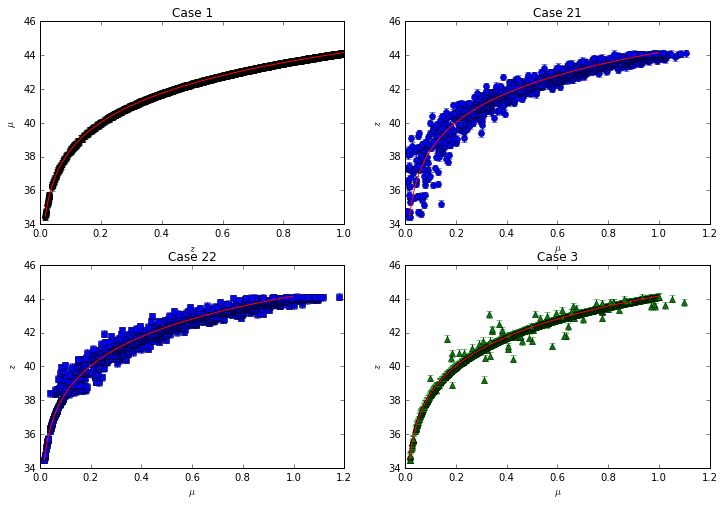

In [29]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[1,1],'height_ratios':[1,1]})
axarr[0,0].errorbar(fd1.z,fd1.mu_o,yerr=[fd1.err_mu,fd1.err_mu],fmt='ko')
axarr[0,0].plot(fd1.z,fd1.mu_t,'r')
axarr[0,0].set_xlabel(r'$z$')
axarr[0,0].set_ylabel(r'$\mu$')
axarr[0,0].set_title('Case 1')
    
axarr[0,1].errorbar(fd1.case21.z,fd1.case21.mu_o,yerr=[fd1.case21.err_mu,fd1.case21.err_mu],fmt='bo')
axarr[0,1].plot(fd1.z,fd1.mu_t,'r')
axarr[0,1].set_ylabel(r'$z$')
axarr[0,1].set_xlabel(r'$\mu$')
axarr[0,1].set_title('Case 21')

axarr[1,0].errorbar(fd1.case22.z,fd1.case22.mu_o,yerr=[fd1.case22.err_mu,fd1.case22.err_mu],fmt='bs')
axarr[1,0].plot(fd1.z,fd1.mu_t,'r')
axarr[1,0].set_ylabel(r'$z$')
axarr[1,0].set_xlabel(r'$\mu$')
axarr[1,0].set_title('Case 22')   

axarr[1,1].errorbar(fd1.case3.z,fd1.case3.mu_o,yerr=[fd1.case3.err_mu,fd1.case3.err_mu],fmt='g^')
axarr[1,1].plot(fd1.z,fd1.mu_t,'r')
axarr[1,1].set_ylabel(r'$z$')
axarr[1,1].set_xlabel(r'$\mu$')
axarr[1,1].set_title('Case 3') 

plt.savefig('datasets_allcases_zf.pdf')
plt.show()